In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import json, pickle, gzip
from gensim.models import Word2Vec
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
! nvidia-smi

Tue Oct  5 11:33:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 24%   52C    P8    18W / 250W |    640MiB / 11018MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 37%   

In [3]:
post_id_2_text = pickle.load(open("../../data/non-graph/posts_id_2_text.pkl", "rb"))

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from transformers import AutoTokenizer, AutoModel
# model_name = "bert-base-uncased"
model_name = "Hate-speech-CNERG/bert-base-uncased-hatexplain"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(device)

Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

cuda:0


In [5]:
class Classifier(nn.Module):
    
    def __init__(self, inp_dim, out_logits):
        super(Classifier, self).__init__()

        self.inp_dim = inp_dim
        self.out_dim = out_logits

        self.fc1 = nn.Linear(inp_dim, 128)
        self.fc2 = nn.Linear(128, out_logits)
    
    def forward(self, x):
        assert x.shape[1] == self.inp_dim

        x = self.fc1(x)
        x = self.fc2(torch.relu(x))
        return torch.log_softmax(x, dim=1)

In [6]:
def get_batches(post_ids, y, device, batch_size):
    num_of_batches = y.shape[0] // batch_size + (1 if y.shape[0] % batch_size else 0)
    shuffled_idxs = np.random.permutation(np.arange(y.shape[0]))
    for i in range(num_of_batches):
        batch_idxs = shuffled_idxs[i*batch_size:(i+1)*batch_size]
        X = np.zeros((batch_idxs.shape[0], 1, max_len), dtype=np.float32)
        for dim1, batch_idx in enumerate(batch_idxs):
            post_id = int(post_ids[batch_idx][:-4])
            batch_post_ids = [post_id]
            for dim2, post_id in enumerate(batch_post_ids):
                text = post_id_2_text[post_id]
                ids = tokenizer(text, max_length=max_len, padding="max_length", truncation=True)['input_ids']
                X[dim1, dim2] = np.array(ids, dtype=int)
        yield torch.IntTensor(X.squeeze()).to(device),\
                torch.LongTensor(y[batch_idxs]).to(device)

In [7]:
def label_train(epoch_num, data, labels, device, optimizer1, optimizer2, criterion, enc, clf, batch_size=32, verbose=False):
    print("Training | Epoch:", epoch_num)
    enc.train()
    clf.train()
    losses = []
    for i, batch in enumerate(tqdm(get_batches(data, labels, device, batch_size),
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0))):
        inp = enc(batch[0])['pooler_output']
        out = clf(inp)
        loss = criterion(out, batch[1])
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        optimizer1.step()
        losses.append(loss.item())
        if verbose:
            print("Epoch:", epoch_num, "| Iter:", i+1, "| Loss:", round(loss.item(), 4))
    clf.eval()
    enc.eval()
    return losses

In [8]:
def get_ids_and_labels(split):
    ids = [i for i in pid[split] if 'gab' in i]
    labels = [label_dict[Counter([j["label"] for j in data[i]["annotators"]]).most_common(1)[0][0]]\
              for i in pid[split] if 'gab' in i]
    return np.array(ids), np.array(labels)

In [9]:
def evaluate(epoch_num, data, labels, device, enc, clf, batch_size=64):
    print("Evaluating | Epoch:", epoch_num)
    enc.eval()
    clf.eval()
    y_preds = []
    y_tests = []
    for batch in tqdm(get_batches(data, labels, device, batch_size),\
                                    total=data.shape[0]//batch_size+(1 if data.shape[0]%batch_size else 0)):
        with torch.no_grad():
            inp = enc(batch[0])['pooler_output']
        out = clf(inp)
        for y in batch[1].cpu().numpy():
            y_tests.append(y)
        for y in out.argmax(dim=1).cpu().numpy():
            y_preds.append(y)
    print(classification_report(y_tests, y_preds))

In [10]:
data_path = '../../data/commons/dataset.json'
pid_path = '../../data/commons/post_id_divisions.json'

with open(pid_path) as f:
    pid = json.load(f)
with open(data_path) as f:
    data = json.load(f)

label_dict = {'normal': 0, 'offensive': 1, 'hatespeech': 2}

train_ids, train_labels = get_ids_and_labels("train")
val_ids, val_labels = get_ids_and_labels("val")
test_ids, test_labels = get_ids_and_labels("test")

In [11]:
train_class_ids = []
train_class_ids.append(sorted(list(train_ids[train_labels==0])))
train_class_ids.append(sorted(list(train_ids[train_labels==1])))
train_class_ids.append(sorted(list(train_ids[train_labels==2])))

Training | Epoch: 1


100%|██████████| 262/262 [01:08<00:00,  3.82it/s]


Evaluating | Epoch: 1


100%|██████████| 33/33 [00:02<00:00, 11.42it/s]

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       216
           1       0.55      0.52      0.54       305
           2       0.79      0.82      0.80       515

    accuracy                           0.69      1036
   macro avg       0.65      0.65      0.65      1036
weighted avg       0.69      0.69      0.69      1036



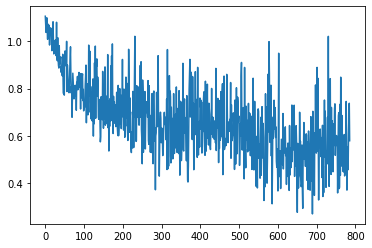

In [16]:
# max_len = 128
# encoder = AutoModel.from_pretrained(model_name).to(device)
# classifier = Classifier(768, 3).to(device)
# optimizer1 = optim.Adam(encoder.parameters(), lr=1e-5)
# optimizer2 = optim.Adadelta(classifier.parameters(), lr=1e-4)
# criterion = nn.NLLLoss()
# losses = []
for i in range(1):
    losses.extend(label_train(i+1, train_ids, train_labels, device, optimizer1,\
                              optimizer2, criterion, encoder, classifier, 32))
    evaluate(i+1, test_ids, test_labels, device, encoder, classifier, batch_size=32)
plt.plot(losses)
plt.show()

In [17]:
torch.save(encoder.state_dict(), "encoder_hxbert.pth")
torch.save(classifier.state_dict(), "classifier_hxbert.pth")

In [13]:
# evaluate(i+1, test_ids, test_labels, device, encoder, classifier, batch_size=32)